In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utilities as ut
import modularised_utils as mut
import scipy.stats as stats

sns.set_theme(style="whitegrid")
seed = 42
np.random.seed(seed)

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
experiment = 'slc'
path = f"data/{experiment}"
saved_folds = joblib.load(f"data/{experiment}/cv_folds.pkl")


In [3]:
# Load the dictionaries containing the results for each optimization method
diroca_results = joblib.load(f"{path}/diroca_cv_results.pkl")
gradca_results = joblib.load(f"{path}/gradca_cv_results.pkl")
baryca_results = joblib.load(f"{path}/baryca_cv_results.pkl")

# Also load the original data dictionary
all_data = ut.load_all_data(experiment)

print("Successfully loaded results for all optimization methods.")
print(f"  - DIROCA results keys: {list(diroca_results.keys())}")
print(f"  - GradCA results keys: {list(gradca_results.keys())}")
print(f"  - BARYCA results keys: {list(baryca_results.keys())}")

Data loaded for 'slc'.
Successfully loaded results for all optimization methods.
  - DIROCA results keys: ['fold_0', 'fold_1']
  - GradCA results keys: ['fold_0', 'fold_1']
  - BARYCA results keys: ['fold_0', 'fold_1']


In [4]:
results_to_evaluate = {
    "DIROCA": diroca_results,
    "GradCA": gradca_results,
    "BARYCA": baryca_results
}

In [5]:
# 3. Unpack the necessary data collections from your loaded data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

In [6]:
def calculate_abstraction_error(T_matrix, Dll_test, Dhl_test):
    """
    Calculates the "0-shift" abstraction error for a given T matrix on a test set.

    This function works in the space of distribution parameters:
    1. It estimates Gaussian parameters (mean, cov) from the LL and HL test samples.
    2. It transforms the LL Gaussian's parameters using the T matrix.
    3. It computes the Wasserstein distance between the transformed LL distribution
       and the actual HL distribution.
    
    Args:
        T_matrix (np.ndarray): The learned abstraction matrix.
        Dll_test (np.ndarray): The low-level endogenous test samples.
        Dhl_test (np.ndarray): The high-level endogenous test samples.
        
    Returns:
        float: The calculated Wasserstein-2 distance.
    """
    # 1. Estimate parameters from the low-level test data
    mu_L_test    = np.mean(Dll_test, axis=0)
    Sigma_L_test = np.cov(Dll_test, rowvar=False)

    # 2. Estimate parameters from the high-level test data
    mu_H_test    = np.mean(Dhl_test, axis=0)
    Sigma_H_test = np.cov(Dhl_test, rowvar=False)

    # 3. Transform the low-level parameters using the T matrix
    # This projects the low-level distribution into the high-level space
    mu_V_predicted    = mu_L_test @ T_matrix.T
    Sigma_V_predicted = T_matrix @ Sigma_L_test @ T_matrix.T
    
    # 4. Compute the Wasserstein distance between the two resulting Gaussians
    # Assuming 'oput.compute_wasserstein' is the function you provided
    try:
        # Your function returns the squared distance, so we take the sqrt
        wasserstein_dist = np.sqrt(mut.compute_wasserstein(mu_V_predicted, Sigma_V_predicted, mu_H_test, Sigma_H_test))
    except Exception as e:
        print(f"  - Warning: Could not compute Wasserstein distance. Error: {e}. Returning NaN.")
        return np.nan

    return wasserstein_dist

print("✓ Helper function 'calculate_abstraction_error' is defined.")

✓ Helper function 'calculate_abstraction_error' is defined.


In [7]:

def apply_shift(clean_data, shift_config, all_var_names, model_level, seed=42):
    """
    Applies a specified contamination to the test data with full flexibility.
    - Handles different shift types (additive, multiplicative).
    - Handles different distributions (gaussian, student-t, exponential).
    - Handles selective application to a subset of variables.
    """
    np.random.seed(seed)
    shift_type = shift_config.get('type')
    dist_type = shift_config.get('distribution', 'gaussian')
    n_samples, n_dims = clean_data.shape

    # Select the correct parameter dictionary for the current model level
    level_key = 'll_params' if model_level == 'L' else 'hl_params'
    params = shift_config.get(level_key, {})
    
    # --- 1. Generate the full noise matrix based on the specified distribution ---
    noise_matrix = np.zeros_like(clean_data)
    if dist_type == 'gaussian':
        mu = np.array(params.get('mu', np.zeros(n_dims)))
        sigma_def = params.get('sigma', np.eye(n_dims))
        sigma = np.diag(np.array(sigma_def)) if np.array(sigma_def).ndim == 1 else np.array(sigma_def)
        noise_matrix = np.random.multivariate_normal(mean=mu, cov=sigma, size=n_samples)

    elif dist_type == 'student-t':
        df = params.get('df', 3)
        loc = np.array(params.get('loc', np.zeros(n_dims)))
        shape_def = params.get('shape', np.eye(n_dims))
        shape = np.diag(np.array(shape_def)) if np.array(shape_def).ndim == 1 else np.array(shape_def)
        noise_matrix = stats.multivariate_t.rvs(loc=loc, shape=shape, df=df, size=n_samples)

    elif dist_type == 'exponential':
        scale = params.get('scale', 1.0)
        noise_matrix = np.random.exponential(scale=scale, size=(n_samples, n_dims))
    
    # --- 2. Apply noise selectively if specified ---
    final_noise = np.zeros_like(clean_data)
    vars_to_affect = params.get('apply_to_vars')

    if vars_to_affect is None:
        # If not specified, apply noise to all variables
        final_noise = noise_matrix
    else:
        # If specified, apply noise only to the selected columns
        try:
            indices_to_affect = [all_var_names.index(var) for var in vars_to_affect]
            final_noise[:, indices_to_affect] = noise_matrix[:, indices_to_affect]
        except ValueError as e:
            print(f"Warning: A variable in 'apply_to_vars' not found. Error: {e}")
            return clean_data # Return clean data if there's a config error

    # --- 3. Return the contaminated data ---
    if shift_type == 'additive':
        return clean_data + final_noise
    elif shift_type == 'multiplicative':
        return clean_data * final_noise
    else:
        raise ValueError(f"Unknown shift type: {shift_type}")

print("✓ Final generalized helper function 'apply_shift' is defined.")

✓ Final generalized helper function 'apply_shift' is defined.


In [8]:
def apply_huber_contamination(clean_data, alpha, shift_config, all_var_names, model_level, seed=42):
    """
    Contaminates a dataset using the Huber model. A fraction 'alpha' of the
    samples are replaced with noisy versions.

    Args:
        clean_data (np.ndarray): The original, clean test data samples.
        alpha (float): The fraction of data to contaminate (between 0 and 1).
        shift_config (dict): Configuration defining the noise for the outliers.
        all_var_names (list): List of all variable names for this data.
        model_level (str): 'L' for low-level or 'H' for high-level.
        
    Returns:
        np.ndarray: The new, contaminated test data.
    """
    np.random.seed(seed)
    if not (0 <= alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    if alpha == 0:
        return clean_data
    
    # Create the fully noisy version of the data using our existing function
    noisy_data = apply_shift(clean_data, shift_config, all_var_names, model_level)
    
    if alpha == 1:
        return noisy_data
        
    n_samples = clean_data.shape[0]
    n_to_contaminate = int(alpha * n_samples)
    
    # Randomly select which rows to replace
    indices_to_replace = np.random.choice(n_samples, n_to_contaminate, replace=False)
    
    # Start with a copy of the clean data
    contaminated_data = clean_data.copy()
    
    # Replace the selected rows with their noisy versions
    contaminated_data[indices_to_replace] = noisy_data[indices_to_replace]
    
    return contaminated_data

print("✓ Helper function 'apply_huber_contamination' is defined.")

✓ Helper function 'apply_huber_contamination' is defined.


In [10]:
# ======================================================================
# 1. CONFIGURE YOUR HUBER TEST HERE
# ======================================================================

# Set the contamination level (e.g., 0.1 means 10% of data will be outliers)
alpha = 1.0

# Define the type of noise to use for the outliers
shift_config = {
    'type': 'additive',
    'distribution': 'student-t',  # Can be 'gaussian', 'student-t', or 'exponential'
    
    'll_params': {
        'df': 3,
        'loc': [0, 0, 0],
        'shape': [0.5, 2.0, 1.0] # Define diagonal elements of the scale matrix
    },
    'hl_params': {
        'df': 5,
        'loc': [0, 0],
        'shape': [[0.8, -0.3], [-0.3, 0.8]] # Define a full scale matrix
    }
}


# ======================================================================
# 2. MAIN EVALUATION LOOP
# ======================================================================

print(f"Running 'Huber-Shift' evaluation with alpha = {alpha}")
huber_shift_records = []

for method_name, results_dict in results_to_evaluate.items():
    for fold_key, fold_results in results_dict.items():
        for run_key, run_data in fold_results.items():
            
            T_learned = run_data['T_matrix']
            test_indices = run_data['test_indices']
            
            errors_per_intervention = []
            for iota in I_ll_relevant:
                # a. Get the clean test data
                Dll_test_clean = Dll_samples[iota][test_indices]
                Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
                
                # b. Apply Huber contamination to create the test set
                Dll_test_contaminated = apply_huber_contamination(Dll_test_clean, alpha, shift_config, ll_var_names, model_level='L')
                Dhl_test_contaminated = apply_huber_contamination(Dhl_test_clean, alpha, shift_config, hl_var_names, model_level='H')
                
                # c. Calculate error on the CONTAMINATED data
                error = calculate_abstraction_error(T_learned, Dll_test_contaminated, Dhl_test_contaminated)
                if not np.isnan(error):
                    errors_per_intervention.append(error)
            
            average_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
            
            record = {
                'method': method_name,
                'fold': int(fold_key.split('_')[1]),
                'run_id': run_key,
                'avg_error_huber': average_error
            }
            huber_shift_records.append(record)

# 3. Display Final Results
huber_shift_df = pd.DataFrame(huber_shift_records)
print("\n\n--- 'Huber-Shift' Evaluation Complete ---")
summary = huber_shift_df.groupby(['method', 'run_id'])['avg_error_huber'].agg(['mean', 'std']).sort_values('mean')
display(summary)

Running 'Huber-Shift' evaluation with alpha = 1.0


--- 'Huber-Shift' Evaluation Complete ---


,,mean,std
method,run_id,,
GradCA,gradca_run,1.964032,0.005390
DIROCA,eps_delta_8,2.062791,0.009017
BARYCA,baryca_run,4.353293,0.024379


# END-TO-END

In [15]:
# # ======================================================================
# # 1. CONTROL PANEL: Configure the Robustness Experiment
# # ======================================================================

# # Define the range of contamination strengths to test.
# # A `noise_scale` of 0 is the "0-shift" case.
# # A `noise_scale` of 1 corresponds to adding N(0, base_sigma).
# noise_levels = np.linspace(0, 2.0, 11) # Test 11 levels from 0 to 2.0

# # Define a base covariance matrix. The noise_level will scale this matrix.
# # This keeps the "shape" of the noise consistent as we increase its magnitude.
# base_sigma_L = np.eye(len(all_data['LLmodel']['graph'].nodes()))
# base_sigma_H = np.eye(len(all_data['HLmodel']['graph'].nodes()))

# # ======================================================================
# # 2. MAIN EXPERIMENT LOOP
# # ======================================================================

# evaluation_records = []

# # --- Outermost Loop: Iterate through each contamination strength ---
# for scale in noise_levels:
#     print(f"\n-- Testing with Noise Scale: {scale:.2f} --")
    
#     # Define the shift configuration for this specific strength level
#     shift_config = {
#         'type': 'additive',
#         'distribution': 'gaussian',
#         'll_params': {
#             'mu': np.zeros(base_sigma_L.shape[0]),
#             # The variance scales with the square of the noise level
#             'sigma': base_sigma_L * (scale**2)
#         },
#         'hl_params': {
#             'mu': np.zeros(base_sigma_H.shape[0]),
#             'sigma': base_sigma_H * (scale**2)
#         }
#     }
    
#     # --- Inner Loops: Iterate through methods and folds (as before) ---
#     for method_name, results_dict in results_to_evaluate.items():
#         for fold_key, fold_results in results_dict.items():
#             for run_key, run_data in fold_results.items():
                
#                 T_learned = run_data['T_matrix']
#                 test_indices = run_data['test_indices']
                
#                 # Calculate the average error across all interventions
#                 errors_per_intervention = []
#                 for iota in I_ll_relevant:
#                     Dll_test_clean = Dll_samples[iota][test_indices]
#                     Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
                    
#                     # Apply the shift for the current noise scale
#                     Dll_test_noisy = apply_shift(Dll_test_clean, shift_config, ll_var_names, model_level='L')
#                     Dhl_test_noisy = apply_shift(Dhl_test_clean, shift_config, hl_var_names, model_level='H')
                    
#                     error = calculate_abstraction_error(T_learned, Dll_test_noisy, Dhl_test_noisy)
#                     if not np.isnan(error):
#                         errors_per_intervention.append(error)
                
#                 average_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                
#                 # Store a detailed record of this run
#                 record = {
#                     'method': method_name,
#                     'fold': int(fold_key.split('_')[1]),
#                     'run_id': run_key,
#                     'noise_scale': scale, # <-- Store the contamination strength
#                     'error': average_error
#                 }
#                 evaluation_records.append(record)

# # 3. Convert all records into a single DataFrame for easy analysis
# results_df = pd.DataFrame(evaluation_records)

# print("\n\n--- Full Evaluation Complete ---")
# print("Results for all contamination levels are stored in 'results_df'.")
# display(results_df)

In [26]:
# Define the range of contamination strengths to test
noise_levels = np.linspace(0, 2.0, 11) 

# Define how many random noise draws to average over for each setting
num_trials = 5 # Using 10-20 is common for stable estimates

# Define a base covariance matrix. The noise_level will scale this matrix.
base_sigma_L = np.eye(len(all_data['LLmodel']['graph'].nodes()))
base_sigma_H = np.eye(len(all_data['HLmodel']['graph'].nodes()))

# ======================================================================
# 2. THE FINAL EVALUATION LOOP
# ======================================================================
evaluation_records = []

# --- Loop 1: Iterate through each method (DIROCA, GradCA, etc.) ---
for method_name, results_dict in results_to_evaluate.items():
    print(f"\n-- Evaluating method: {method_name} --")
    
    # --- Loop 2: Iterate through each contamination strength ---
    for scale in noise_levels:
        
        # --- Loop 3: Iterate through each cross-validation fold ---
        for i, fold_info in enumerate(saved_folds):
            
            # This inner dict will hold results for different hyperparameter runs (e.g., different eps_delta)
            fold_results = results_dict[f'fold_{i}']
            for run_key, run_data in fold_results.items():

                T_learned = run_data['T_matrix']
                test_indices = run_data['test_indices']
                
                # --- Loop 4 (NEW): Average over multiple random noise trials ---
                errors_for_this_trial_set = []
                for trial in range(num_trials):
                
                    # This is the average error across all interventions for a SINGLE trial
                    errors_per_intervention = []
                    for iota in I_ll_relevant:
                        Dll_test_clean = Dll_samples[iota][test_indices]
                        Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
                        
                        shift_config = {
                            'type': 'additive', 'distribution': 'gaussian',
                            'll_params': {'mu': np.zeros(base_sigma_L.shape[0]), 'sigma': base_sigma_L * (scale**2)},
                            'hl_params': {'mu': np.zeros(base_sigma_H.shape[0]), 'sigma': base_sigma_H * (scale**2)}
                        }
                        
                        Dll_test_noisy = apply_shift(Dll_test_clean, shift_config, ll_var_names, model_level='L')
                        Dhl_test_noisy = apply_shift(Dhl_test_clean, shift_config, hl_var_names, model_level='H')
                        
                        error = calculate_abstraction_error(T_learned, Dll_test_noisy, Dhl_test_noisy)
                        if not np.isnan(error):
                            errors_per_intervention.append(error)
                    
                    # Calculate the average error for this single trial
                    avg_error_for_trial = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    errors_for_this_trial_set.append(avg_error_for_trial)
                
                # Calculate the final error by averaging across all the random trials
                final_avg_error = np.mean(errors_for_this_trial_set)

                # Store a detailed record
                record = {
                    'method': method_name,
                    'run_id': run_key,
                    'noise_scale': scale,
                    'fold': i,
                    'error': final_avg_error 
                }
                evaluation_records.append(record)

# 3. Convert all records into a single DataFrame for easy analysis
results_df = pd.DataFrame(evaluation_records)

print("\n\n--- Full Evaluation Complete ---")
print("Results for all contamination levels are stored in 'results_df'.")
display(results_df)


-- Evaluating method: DIROCA --

-- Evaluating method: GradCA --

-- Evaluating method: BARYCA --


--- Full Evaluation Complete ---
Results for all contamination levels are stored in 'results_df'.


,method,run_id,noise_scale,fold,error
0,DIROCA,eps_delta_8,0.0,0,1.280884
1,DIROCA,eps_delta_8,0.0,1,1.286380
2,DIROCA,eps_delta_8,0.2,0,1.241199
3,DIROCA,eps_delta_8,0.2,1,1.250082
4,DIROCA,eps_delta_8,0.4,0,1.209941
...,...,...,...,...,...
61,BARYCA,baryca_run,1.6,1,3.492768
62,BARYCA,baryca_run,1.8,0,3.730566
63,BARYCA,baryca_run,1.8,1,3.731025
64,BARYCA,baryca_run,2.0,0,3.979953


In [23]:
# 1. First, calculate the summary statistics DataFrame using groupby and agg
print("--- Final Summary (Mean Error ± Std Dev across all folds) ---")
# Corrected line
summary_stats = results_df.groupby(['method', 'run_id'])['error'].agg(['mean', 'std']).sort_values('mean')
# Display the raw summary DataFrame
display(summary_stats)


# 2. Now, print the results in your custom table format
print("\n" + "="*60)
print(f"{'Method/Run':<35} | {'Mean Error ± Std Dev'}")
print("="*60)

for index, row in summary_stats.iterrows():
    # Unpack the multi-index
    method, run_id = index
    
    mean_val = row['mean']
    std_val = row['std']
    
    # Create a clean name for display in the table
    display_name = f"{method} ({run_id})"
    
    print(f"{display_name:<35} | {mean_val:>7.4f} ± {std_val:.4f}")

print("="*60)

--- Final Summary (Mean Error ± Std Dev across all folds) ---


,,mean,std
method,run_id,,
DIROCA,eps_delta_8,1.313407,0.108554
GradCA,gradca_run,1.358966,0.151457
BARYCA,baryca_run,3.057893,0.484017



Method/Run                          | Mean Error ± Std Dev
DIROCA (eps_delta_8)                |  1.3134 ± 0.1086
GradCA (gradca_run)                 |  1.3590 ± 0.1515
BARYCA (baryca_run)                 |  3.0579 ± 0.4840


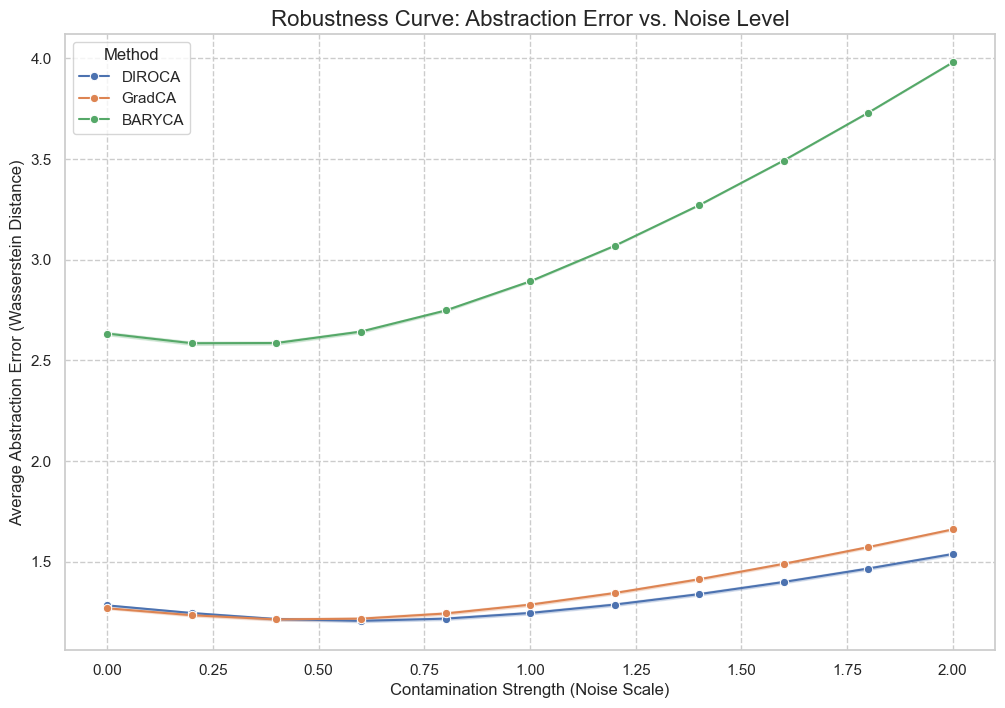


--- Statistical Significance Test: DIROCA vs. GradCA (paired-t) ---
  - At Noise Level 0.00: p-value = 0.0567 (No significant difference)
  - At Noise Level 0.20: p-value = 0.0548 (No significant difference)
  - At Noise Level 0.40: p-value = 0.2478 (No significant difference)
  - At Noise Level 0.60: p-value = 0.0186 (Significant difference, DIROCA is better)
  - At Noise Level 0.80: p-value = 0.0003 (Significant difference, DIROCA is better)
  - At Noise Level 1.00: p-value = 0.0049 (Significant difference, DIROCA is better)
  - At Noise Level 1.20: p-value = 0.0065 (Significant difference, DIROCA is better)
  - At Noise Level 1.40: p-value = 0.0069 (Significant difference, DIROCA is better)
  - At Noise Level 1.60: p-value = 0.0070 (Significant difference, DIROCA is better)
  - At Noise Level 1.80: p-value = 0.0069 (Significant difference, DIROCA is better)
  - At Noise Level 2.00: p-value = 0.0066 (Significant difference, DIROCA is better)

--- Statistical Significance Test: DIROC

In [28]:
def plot_robustness_curves(results_df):
    """
    Plots the abstraction error as a function of contamination strength for each method.
    """
    plt.figure(figsize=(12, 8))
    
    # Seaborn's lineplot automatically calculates and plots the mean and 
    # a 95% confidence interval across the folds for each point.
    sns.lineplot(
        data=results_df, 
        x='noise_scale', 
        y='error', 
        hue='method', 
        marker='o',
        errorbar=('ci', 95) # Show 95% confidence interval
    )
    
    plt.title('Robustness Curve: Abstraction Error vs. Noise Level', fontsize=16)
    plt.xlabel('Contamination Strength (Noise Scale)', fontsize=12)
    plt.ylabel('Average Abstraction Error (Wasserstein Distance)', fontsize=12)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.show()


def perform_statistical_tests(results_df, method1, method2, test_type='paired-t'):
    """
    Compares two methods at each noise level using a statistical test.
    """
    print(f"\n--- Statistical Significance Test: {method1} vs. {method2} ({test_type}) ---")
    
    # Ensure data is sorted by fold to maintain pairing for paired tests
    df_sorted = results_df.sort_values('fold')
    noise_levels = sorted(df_sorted['noise_scale'].unique())
    
    for level in noise_levels:
        df_level = df_sorted[df_sorted['noise_scale'] == level]
        
        errors1 = df_level[df_level['method'] == method1]['error'].dropna()
        errors2 = df_level[df_level['method'] == method2]['error'].dropna()

        if len(errors1) != len(errors2) or len(errors1) < 2:
            print(f"  - At Noise Level {level:.2f}: Not enough data to perform test.")
            continue
            
        # Perform the requested statistical test
        if test_type == 'paired-t':
            stat, p_value = stats.ttest_rel(errors1, errors2)
        elif test_type == 'wilcoxon':
            # Wilcoxon is for paired, non-parametric data
            stat, p_value = stats.wilcoxon(errors1, errors2)
        else: # Independent t-test
            stat, p_value = stats.ttest_ind(errors1, errors2)

        # Report the result
        print(f"  - At Noise Level {level:.2f}: p-value = {p_value:.4f}", end="")
        if p_value < 0.05:
            winner = method1 if np.mean(errors1) < np.mean(errors2) else method2
            print(f" (Significant difference, {winner} is better)")
        else:
            print(" (No significant difference)")

# ======================================================================
# 3. RUN THE ANALYSIS
# ======================================================================

# First, generate the main plot
plot_robustness_curves(results_df)

# Then, run statistical tests to compare pairs of methods
# A paired t-test is appropriate here because the methods are tested on the same k-fold splits.
perform_statistical_tests(results_df, 'DIROCA', 'GradCA', test_type='paired-t')
perform_statistical_tests(results_df, 'DIROCA', 'BARYCA', test_type='paired-t')

# END TO END + HUBER

In [37]:
# Define the fraction of data to contaminate (0=0-shift, 1=rho-shift)
alpha_values = [0.0, 0.1, 0.5, 1.0]

# Define the contamination strength for the outliers
noise_levels = np.linspace(0, 2.0, 11) 

# Define how many random noise draws to average over for each setting
num_trials = 5 # A higher number gives a more stable estimate

# Define base covariance matrices
base_sigma_L = np.eye(len(all_data['LLmodel']['graph'].nodes()))
base_sigma_H = np.eye(len(all_data['HLmodel']['graph'].nodes()))

# ======================================================================
# 2. THE FINAL UNIFIED EVALUATION LOOP
# ======================================================================
print("🚀 Starting definitive robustness evaluation...")
evaluation_records = []

# --- Loop 1: Iterate through each contamination fraction ---
for alpha in alpha_values:
    print(f"\n===== Evaluating with Alpha (Contamination Fraction) = {alpha} =====")
    
    # --- Loop 2: Iterate through each contamination strength ---
    for scale in noise_levels:
        
        # --- Loop 3 (RESTORED): Iterate through multiple random trials ---
        for trial in range(num_trials):
            
            # This loop runs the full k-fold test for a single trial
            for i, fold_info in enumerate(saved_folds):
                for method_name, results_dict in results_to_evaluate.items():
                    fold_results = results_dict[f'fold_{i}']
                    for run_key, run_data in fold_results.items():

                        T_learned = run_data['T_matrix']
                        test_indices = run_data['test_indices']
                        
                        # The avg error across interventions for this single trial & fold
                        errors_per_intervention = []
                        for iota in I_ll_relevant:
                            Dll_test_clean = Dll_samples[iota][test_indices]
                            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
                            
                            shift_config = {
                                'type': 'additive', 'distribution': 'gaussian',
                                'll_params': {'mu': np.zeros(base_sigma_L.shape[0]), 'sigma': base_sigma_L * (scale**2)},
                                'hl_params': {'mu': np.zeros(base_sigma_H.shape[0]), 'sigma': base_sigma_H * (scale**2)}
                            }
                            
                            Dll_test_contaminated = apply_huber_contamination(Dll_test_clean, alpha, shift_config, ll_var_names, 'L')
                            Dhl_test_contaminated = apply_huber_contamination(Dhl_test_clean, alpha, shift_config, hl_var_names, 'H')
                            
                            error = calculate_abstraction_error(T_learned, Dll_test_contaminated, Dhl_test_contaminated)
                            if not np.isnan(error):
                                errors_per_intervention.append(error)
                        
                        avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                        
                        # Store a detailed record for every trial and every fold
                        record = {
                            'method': method_name,
                            'run_id': run_key,
                            'alpha': alpha,
                            'noise_scale': scale,
                            'trial': trial,
                            'fold': i,
                            'error': avg_error
                        }
                        evaluation_records.append(record)

# 3. Convert all records into a single DataFrame
final_results_df = pd.DataFrame(evaluation_records)

print("\n\n--- Full Evaluation Complete ---")
print("All detailed per-trial and per-fold results are stored in 'final_results_df'.")
display(final_results_df.head())

🚀 Starting definitive robustness evaluation...

===== Evaluating with Alpha (Contamination Fraction) = 0.0 =====

===== Evaluating with Alpha (Contamination Fraction) = 0.1 =====

===== Evaluating with Alpha (Contamination Fraction) = 0.5 =====

===== Evaluating with Alpha (Contamination Fraction) = 1.0 =====


--- Full Evaluation Complete ---
All detailed per-trial and per-fold results are stored in 'final_results_df'.


,method,run_id,alpha,noise_scale,trial,fold,error
0,DIROCA,eps_delta_8,0.0,0.0,0,0,1.280884
1,GradCA,gradca_run,0.0,0.0,0,0,1.265300
2,BARYCA,baryca_run,0.0,0.0,0,0,2.641450
3,DIROCA,eps_delta_8,0.0,0.0,0,1,1.286380
4,GradCA,gradca_run,0.0,0.0,0,1,1.273351


In [38]:
# 1. First, calculate the summary statistics DataFrame using groupby and agg
print("--- Final Summary (Mean Error ± Std Dev across all folds) ---")
# Corrected line
summary_stats = final_results_df.groupby(['method', 'run_id'])['error'].agg(['mean', 'std']).sort_values('mean')
# Display the raw summary DataFrame
display(summary_stats)


# 2. Now, print the results in your custom table format
print("\n" + "="*60)
print(f"{'Method/Run':<35} | {'Mean Error ± Std Dev'}")
print("="*60)

for index, row in summary_stats.iterrows():
    # Unpack the multi-index
    method, run_id = index
    
    mean_val = row['mean']
    std_val = row['std']
    
    # Create a clean name for display in the table
    display_name = f"{method} ({run_id})"
    
    print(f"{display_name:<35} | {mean_val:>7.4f} ± {std_val:.4f}")

print("="*60)

--- Final Summary (Mean Error ± Std Dev across all folds) ---


,,mean,std
method,run_id,,
DIROCA,eps_delta_8,1.270339,0.061367
GradCA,gradca_run,1.282070,0.090779
BARYCA,baryca_run,2.781090,0.331379



Method/Run                          | Mean Error ± Std Dev
DIROCA (eps_delta_8)                |  1.2703 ± 0.0614
GradCA (gradca_run)                 |  1.2821 ± 0.0908
BARYCA (baryca_run)                 |  2.7811 ± 0.3314
